In [258]:
from matplotlib import pyplot as plt
import numpy as np
import math
import cv2

In [259]:
OCTV = 4
INTVL = 2
SIFT_INTVLS = 3
SIFT_SIGMA = 1.6
SIFT_INIT_SIGMA = 0.5
SIFT_IMG_BORDER = 5
SIFT_MAX_INTERP_STEPS = 5

In [260]:
def downsample(img):
	return cv2.resize(img, (img.shape[1]*2,img.shape[0]*2), interpolation=cv2.INTER_AREA)

In [261]:
def init_img(img, img_dbl=False, sigma=2):
    shape = img.shape
    # converting to grayscale if needed
    if len(shape) > 2:
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    else:
        img_gray = img
    if img_dbl:
        dbl = cv2.resize(img_gray, (img_gray.shape[1]*2,img_gray.shape[0]*2), interpolation=cv2.INTER_CUBIC)
        sig_diff = math.sqrt(sigma**2 - SIFT_INIT_SIGMA**2 * 4)
        return cv2.GaussianBlur(dbl, (0,0), sig_diff)
    else :
        sig_diff = math.sqrt(sigma**2 - SIFT_INIT_SIGMA**2)
        return cv2.GaussianBlur(img_gray, (0,0), sig_diff)

In [262]:
def build_gauss_pyr(img, octv=OCTV, intvl=INTVL, sigma=SIFT_SIGMA):
    k = 2**(1/2)
    gauss_pyr = []
    for o in range(octv):
        sig = 1 * k**o
        octave = []
        for i in range(intvl + 3) :
            if o == 0 and i == 0 :
                octave.append(img)
            elif i == 0 :
                octave.append(downsample(gauss_pyr[-1][-1]))
            else :
                octave.append(cv2.GaussianBlur(octave[-1], (0,0), sig))
        gauss_pyr.append(octave)
    return gauss_pyr

In [263]:
def build_dog_pyr(gauss_pyr):
    dog_pyr = []
    for o in range(len(gauss_pyr)):
        dog = []
        for i in range(len(gauss_pyr[o])-1):
#             ret,th = cv2.threshold(gauss_pyr[o][i+1] - gauss_pyr[o][i],0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
#             th = cv2.adaptiveThreshold(gauss_pyr[o][i+1] - gauss_pyr[o][i], 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 115, 1)
            dog.append(gauss_pyr[o][i+1] - gauss_pyr[o][i])
        dog_pyr.append(dog)
    return dog_pyr

In [264]:
def is_extremum(dog, octv, intvl, r, c):
    val = dog[octv][intvl][r,c]
    minVal, maxVal, minLoc, maxLoc = cv2.minMaxLoc(dog[octv][intvl][r-1:r+1,c-1:c+1])
    if minVal != val and maxVal != val :
        return False
    elif maxVal != val :
        for i in [-1, 0, +1]:
            for j in [-1, 0, +1]:
                for k in [-1, 0, +1]:
                    if(val > dog[octv][intvl+i][r+j,c+k]):
                        return False
    elif minVal != val :
        for i in [-1, 0, +1]:
            for j in [-1, 0, +1]:
                for k in [-1, 0, +1]:
                    if(val < dog[octv][intvl+i][r+j,c+k]):
                        return False
    else :
        return True

In [265]:
def deriv_3D(dog, octv, intvl, r, c):
    dx = (dog[octv][intvl][r, c+1] - dog[octv][intvl][r, c-1])/2
    dy = (dog[octv][intvl][r+1, c] - dog[octv][intvl][r-1, c])/2
    ds = (dog[octv][intvl+1][r, c] - dog[octv][intvl-1][r, c])/2
    return np.array([dx, dy, ds])

In [266]:
def hessian_3D(dog, octv, intvl, r, c):
    v = dog[octv][intvl][r,c]
    dxx = dog[octv][intvl][r,c+1] + dog[octv][intvl][r,c-1] - 2*v
    dyy = dog[octv][intvl][r+1,c] + dog[octv][intvl][r-1,c] - 2*v
    dss = dog[octv][intvl+1][r,c] + dog[octv][intvl-1][r,c] - 2*v
    dxy = (dog[octv][intvl][r+1,c+1] + dog[octv][intvl][r-1,c-1] -
           dog[octv][intvl][r-1,c+1] - dog[octv][intvl][r+1,c-1] )/4
    dxs = (dog[octv][intvl+1][r,c+1] + dog[octv][intvl-1][r,c-1] -
           dog[octv][intvl-1][r,c+1] - dog[octv][intvl+1][r,c-1] )/4
    dys = (dog[octv][intvl+1][r+1,c] + dog[octv][intvl-1][r-1,c] -
           dog[octv][intvl+1][r-1,c] - dog[octv][intvl-1][r+1,c] )/4
    return np.array([[dxx, dxy, dxs],
                     [dxy, dyy, dys],
                     [dxs, dys, dss]])

In [267]:
def interp_step(dog, octv, intvl, r, c):
    dD = deriv_3D(dog, octv, intvl, r, c)
    H = hessian_3D(dog, octv, intvl, r, c)
    H_inv = np.zeros(H.T.shape)
    cv2.invert(H, H_inv, cv2.DECOMP_SVD)
    gm = cv2.gemm(H_inv, dD, -1, None, 0)
    return gm

In [268]:
def interp_contr(dog, octv, intvl, r, c):#, xi, xr, xc):
    [xi, xr, xc] = interp_step(dog, octv, intvl, r, c)
    dD = np.array([deriv_3D(dog, octv, intvl, r, c)])
    X = np.array([xc, xr, xi])
    m = np.dot(dD, X)
    contr = dog[octv][intvl][r,c] + m[0] * 2
    return contr[0]

In [269]:
def round(x):
    if x - int(x) < int(x+1) - x:
        return int(x) + 1
    else : return int(x)

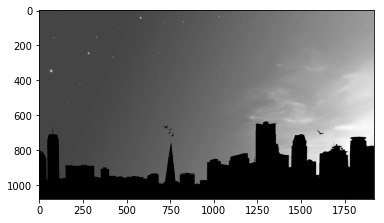

In [270]:
img = cv2.imread('1.jpg')
# img = cv2.imread('2.png')
gray = init_img(img)
plt.imshow(gray, cmap='gray')
plt.show()
# plt.imshow(scaleArea[j][i],cmap = 'gray')
# plt.title('Original[%d,%d]' % (j, i)), plt.xticks([]), plt.yticks([])
# plt.show()

In [271]:
gauss_pyr = build_gauss_pyr(gray)

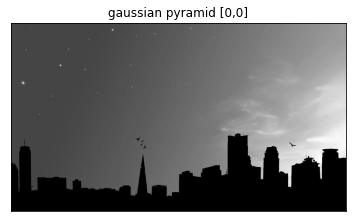

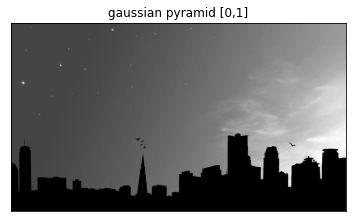

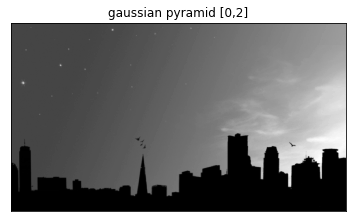

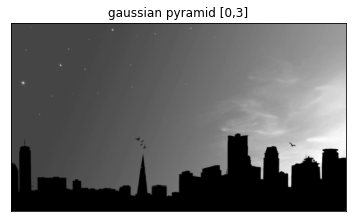

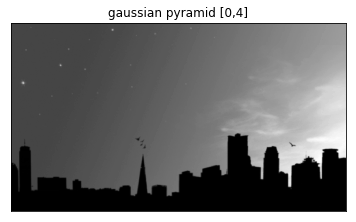

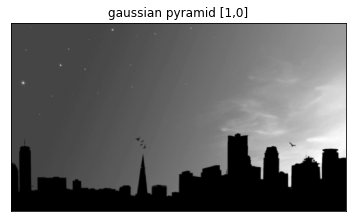

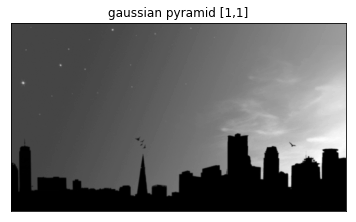

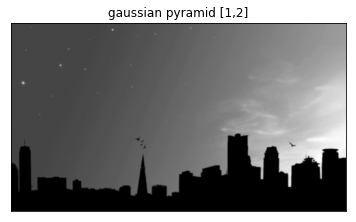

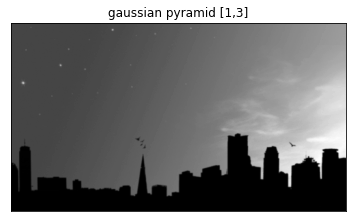

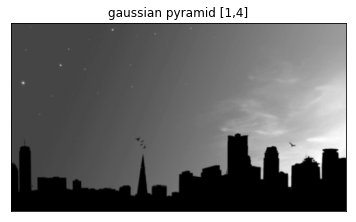

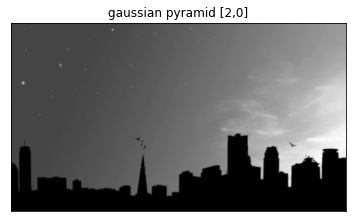

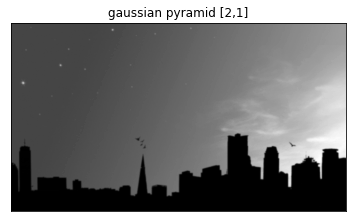

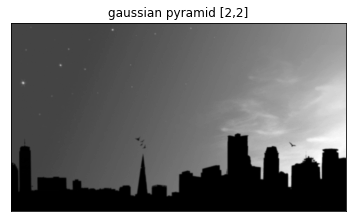

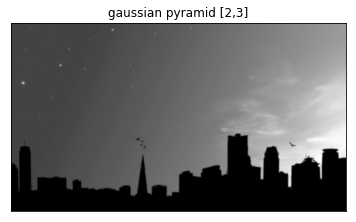

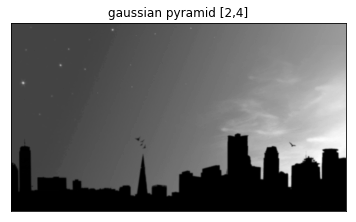

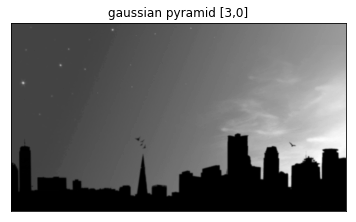

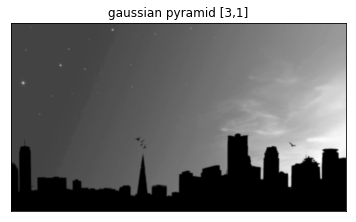

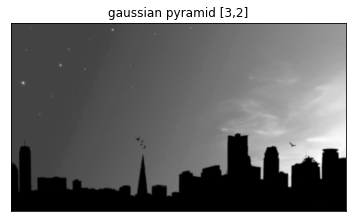

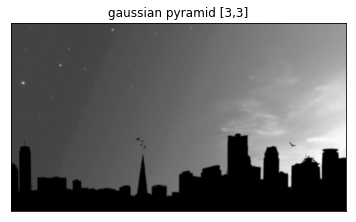

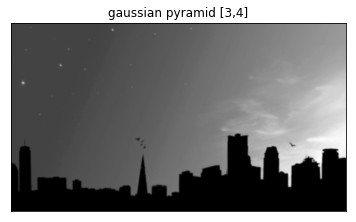

In [272]:
# printing the gaussian pyramid
for o in range(len(gauss_pyr)):
    for i in range(len(gauss_pyr[o])):
        plt.imshow(gauss_pyr[o][i], cmap='gray')
        plt.title('gaussian pyramid [%d,%d]' % (o, i)), plt.xticks([]), plt.yticks([])
        plt.show()

In [273]:
dog_pyr = build_dog_pyr(gauss_pyr)

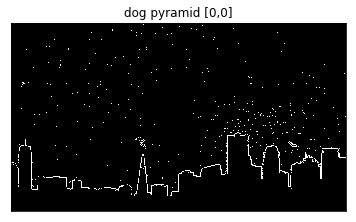

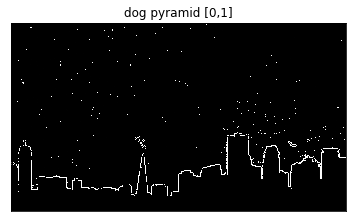

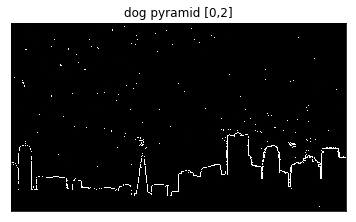

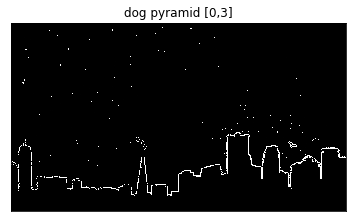

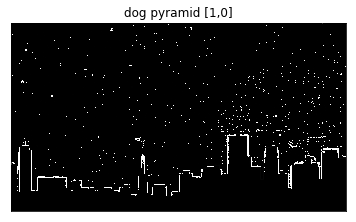

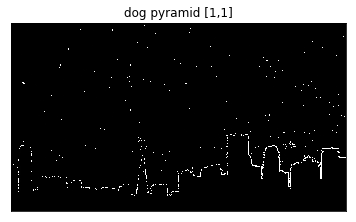

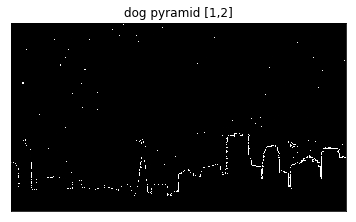

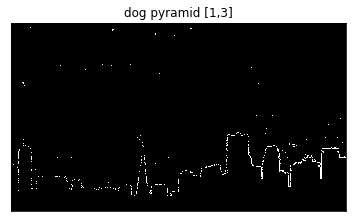

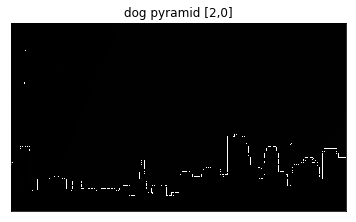

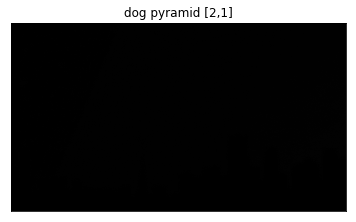

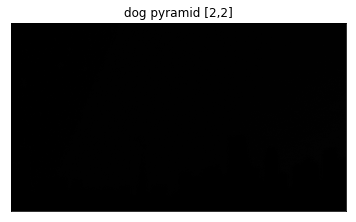

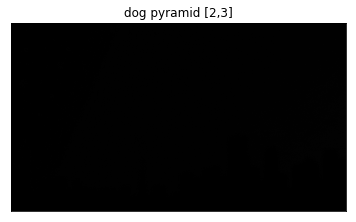

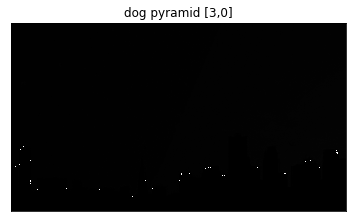

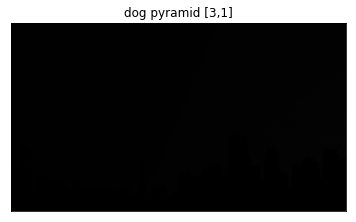

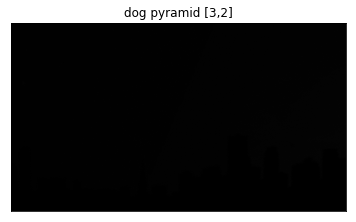

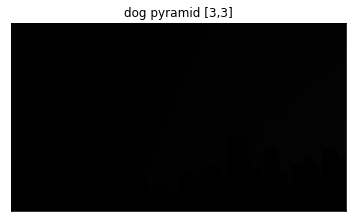

In [274]:
# printing the Difference of Gaussian Pyramid
for o in range(len(dog_pyr)):
    for i in range(len(dog_pyr[o])):
        plt.imshow(dog_pyr[o][i], cmap='gray')
        plt.title('dog pyramid [%d,%d]' % (o, i)), plt.xticks([]), plt.yticks([])
        plt.show()

In [275]:
# high_contr = []
# for o in range(len(dog_pyr)):
#     print(o)
#     contr = []
#     for i in range(len(dog_pyr[o])):
#         new_contr = np.zeros(dog_pyr[o][i].shape)
#         for r in range(dog_pyr[o][i].shape[0]):
#             for c in range(dog_pyr[o][i].shape[1]):
#                 if dog_pyr[o][i][r,c] > 200:
#                     new_contr[r,c] = 255
#         contr.append(new_contr)
#     high_contr.append(contr)

In [276]:
# # printing the high contr
# for o in range(len(high_contr)):
#     for i in range(len(high_contr[o])):
#         plt.imshow(high_contr[o][i], cmap='gray')
#         plt.title('dog pyramid [%d,%d]' % (o, i)), plt.xticks([]), plt.yticks([])
#         plt.show()

In [ ]:
high_contr = dog_pyr
extremum = []
for o in range(len(high_contr)):
    print(o)
    ext = []
    for i in range(1, len(high_contr[o])-1):
        new_ext = np.zeros(high_contr[o][i].shape)
        for r in range(1, high_contr[o][i].shape[0]-1):
            for c in range(1, high_contr[o][i].shape[1]-1):
                if is_extremum(high_contr, o, i, r, c):
                    new_ext[r,c] = 255
        ext.append(new_ext)
    extremum.append(contr)

0
1
2


In [ ]:
for o in range(len(extremum)):
    for i in range(len(extremum[o])):
        plt.imshow(extremum[o][i], cmap='gray')
        plt.title('extremum [%d,%d]' % (o, i)), plt.xticks([]), plt.yticks([])
        plt.show()

In [ ]:
def interp_extremum(dog_pyr, octv, intvl, r, c, contr_thrsh):
    flag = False
    for i in range(SIFT_MAX_INTERP_STEPS):
        xc, xr, xs = interp_step(dog_pyr, octv, intvl, r, c)
        if abs(xi) < 0.5 and abs(xr) < 0.5 and abs(xc) < 0.5:
            break;
        new_c = c + round(xc)
        new_r = r + round(xr)
        new_s = s + round(xs)

        if new_s < 1 or intvl > 2: return None
        if new_c < SIFT_IMG_BORDER or r < SIFT_IMG_BORDER: return None
        if new_c > dog_pyr[octv][intvl].shape[1] - SIFT_IMG_BORDER : return None
        if new_r > dog_pyr[octv][intvl].shape[0] - SIFT_IMG_BORDER : return None
        if i == SIFT_MAX_INTERP_STEPS - 1: flag = True
    if flag: return None
    contr = interp_contr(dog_pyr, octv, intvl, r, c)
    if abs(contr) < contr_thrsh/len(dog_pyr[octv]):
        return None
    feature = []
# 		  feat->img_pt.x = feat->x = ( c + xc ) * pow( 2.0, octv );
# 		  feat->img_pt.y = feat->y = ( r + xr ) * pow( 2.0, octv );
# 		  ddata->r = r;
# 		  ddata->c = c;
# 		  ddata->octv = octv;
# 		  ddata->intvl = intvl;
# 		  ddata->subintvl = xi;
    # store the feature data and return it
    return None # feature

In [ ]:
def is_too_edge_like(img, r, c, curv_thrsh):
    """	Validate the significance of the feature(corner)
    ckeck whether the point [r,c] is a part of the edge or not
    
    Parameters :
    img(2D numpy.array): image need to validate for feature
    r(int): row index at which feature validation is to be done
    c(int): column index at which featurevalidation is to be done
    curv_thrsh(double): high threshhold for on ratio of principal curvatures
    
    Returns:
    bool: True - feature is to be ignored
          False - feature is to be considered for further processign
    """
    dxx = img[r,c+1] + img[r,c-1] - 2*img[r,c]
    dyy = img[r+1,c] + img[r-1,c] - 2*img[r,c]
    dxy = (img[r+1,c+1] + img[r-1,c-1] -
        img[r+1,c-1] - img[r-1,c+1]) / 4
    trr = dxx + dyy
    det = dxx * dyy - dxy**2
    if det <= 0:
        return True
    elif tr**2 / det < (curv_thrsh + 1)**2 / curv_thrsh:
        return False
    else:
        return True